In [1]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [2]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()
       
        m2      = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm2, ym2  = m2(LON, LAT)
        im2     = m2.plot(xm2,ym2,'.', color='k',linewidth=2.)

        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

In [284]:
def investigate_traj(figsize, proj, nb_traj, hfacc_level):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.basemap import Basemap
    import cmocean
    
    fig     = plt.figure(figsize=figsize)
    
    if proj=='ortho':
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0, resolution="l")
    elif proj=='merc':
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-40.,llcrnrlon=120.,urcrnrlon=270.,lat_ts=-60.,resolution='c')
    elif proj=='lamb':
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
            
    # Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
    xm, ym  = m(Xf, Yf)
    im      = m.contourf(xm, ym, hFacC[hfacc_level,...], extend='both', cmap='Greys_r')
    
    # Plot the salinity
    xm, ym  = m(XC, YC)
    im      = m.contourf(xm, ym, mean_Salt_30, levels=np.linspace(32.8,35.3,50), extend='both', cmap=cmocean.cm.haline)
    cbar    = m.colorbar(im,pad='10%')
    cbar.set_label('Salinity', fontsize =16)

    # Plot all the traj
    for p in nb_traj: 
        xm, ym  = m(LON[:,p], LAT[:,p])
        im      = m.plot(xm, ym, '-', color='orange',linewidth=0.4)
        xm, ym  = m(LON[0,p], LAT[0,p])
        im      = m.plot(xm, ym, '.', color='yellow',linewidth=2.)
        xm, ym  = m(LON[-1,p], LAT[-1,p])
        im      = m.plot(xm, ym, '*', color='r',linewidth=3.)
        
    m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
    #plt.title('10 000 parti, 5 years (hFacC and S at 30 m)', fontsize=18)
    #plt.savefig(path_save + title_save, bbox_inches='tight')

In [4]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle
import cmocean

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

In [5]:
# Mercator salinity
mean_Salt_surf = pickle_load('mean_Salt_surf_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_30     = pickle_load('mean_Salt_30_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_100   = pickle_load('mean_Salt_100_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_200   = pickle_load('mean_Salt_200_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_500   = pickle_load('mean_Salt_500_2', '/data/ebent/Bigger_domain/', verbose=False)

# Mercator temperature
mean_Theta_surf = pickle_load('mean_Theta_surf_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_30     = pickle_load('mean_Theta_30_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_100   = pickle_load('mean_Theta_100_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_200   = pickle_load('mean_Theta_200_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_500   = pickle_load('mean_Theta_500_2', '/data/ebent/Bigger_domain', verbose=False)

In [6]:
# Load files
file1 = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

In [7]:
# This is hFacC for the SOUTHERN HEMISPHERE

file_h = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file_h.get('hFacC')
hFacC = np.array(hFacC)
Xf = file_h.get('XC')
Xf = np.array(Xf)
Yf = file_h.get('YC')
Yf = np.array(Yf)

In [8]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"
lon_min   = 1440 
lon_max   = 3241
lat_min   = 0 
lat_max   = 1024

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04
XC, YC    = np.meshgrid(XC, YC)

hfacc = hFacC[:, lat_min:lat_max, lon_min:lon_max]

In [9]:
southern_front = pickle_load('ACC_southern_front', '/data/ebent/', verbose=False)
southern_front = np.ma.masked_array(southern_front, mask=False)

In [10]:
E_boundary = 12 # 121,04 degrees
W_boundary = 1560 # 250,04 degrees

In [11]:
# Create a meshgrid to plot in index coordinates
xc = np.arange(1801)
yc = np.arange(1024)
xc, yc = np.meshgrid(xc,yc)

In [12]:
npts = 10000

***

# Load variables

In [298]:
path = '/data/ebent/Octopus/output/725m_12_10_4/'

In [302]:
DEP = pickle_load('DEP', path)
LAT = pickle_load('LAT', path)
LON = pickle_load('LON', path)

zround = pickle_load('zround', path)
yround = pickle_load('yround', path)
xround = pickle_load('xround', path)

('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/xround.npy')


In [300]:
Z1 = pickle_load('Z1', path)
Z2 = pickle_load('Z2', path)
Z3 = pickle_load('Z3', path)
Z4 = pickle_load('Z4', path)
Z5 = pickle_load('Z5', path)
dead = pickle_load('dead', path)

('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/Z1.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/Z2.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/Z3.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/Z4.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/Z5.npy')
('loaded from : ', '/data/ebent/Octopus/output/725m_12_10_4/dead.npy')


***

# Plots

# Definition of the different zones

In [240]:
look_index = np.where(southern_front[:,E_boundary]==0)[0]
look_index2 = np.where(southern_front[:,W_boundary]==0)[0]

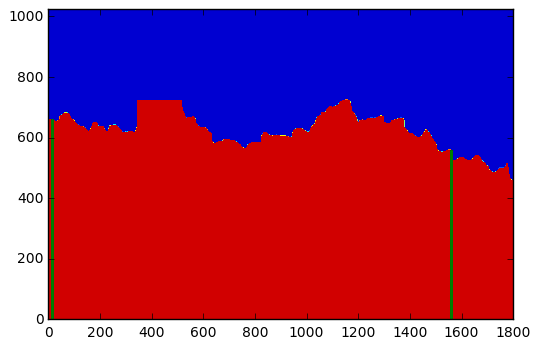

In [137]:
plt.contourf(xc, yc, southern_front)
tmp = np.ones(look_index[0])*E_boundary
tmp2 = np.ones(look_index2[0])*W_boundary
plt.plot(tmp, yc[:look_index[0],:], '-g')
plt.plot(tmp2, yc[:look_index2[0],:], '-g')
plt.show()

# Plot of the traj of the experiment 

In [243]:
XC, YC    = np.meshgrid(XC, YC)

BEFORE mask of wrong initialisation

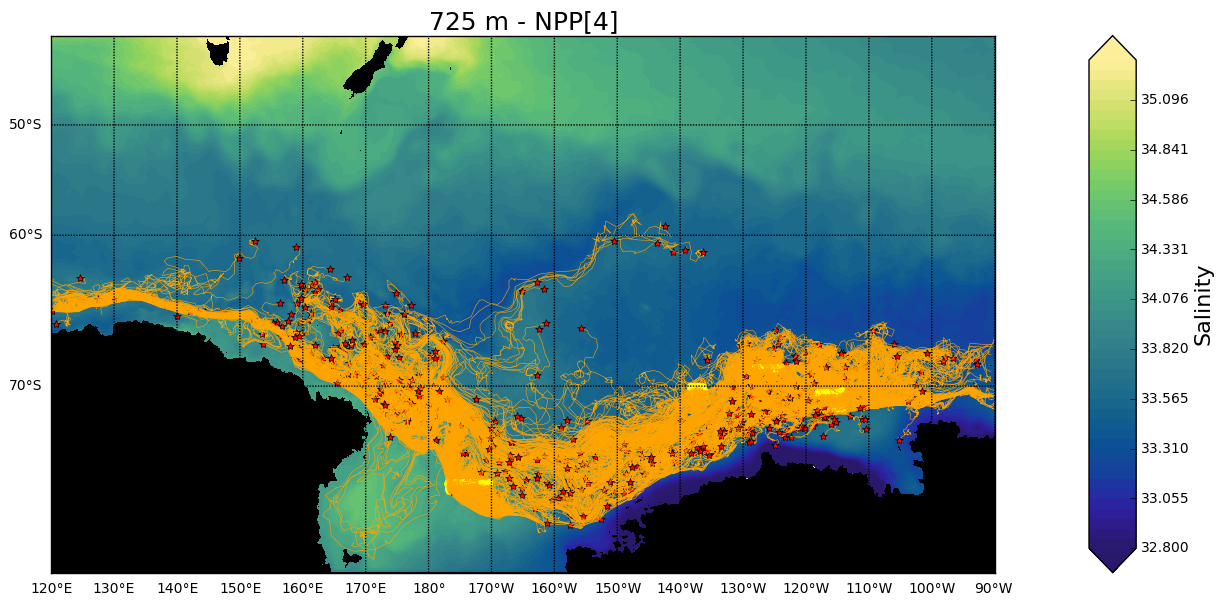

In [90]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(1000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

AFTER mask of wrong initialisation

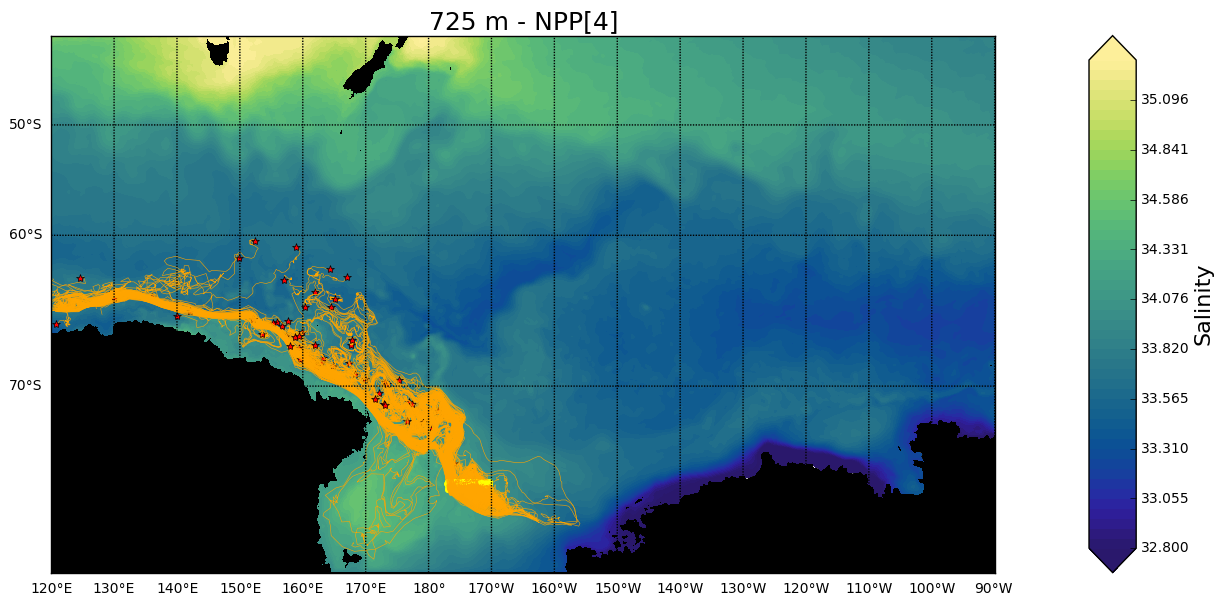

In [244]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(1000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

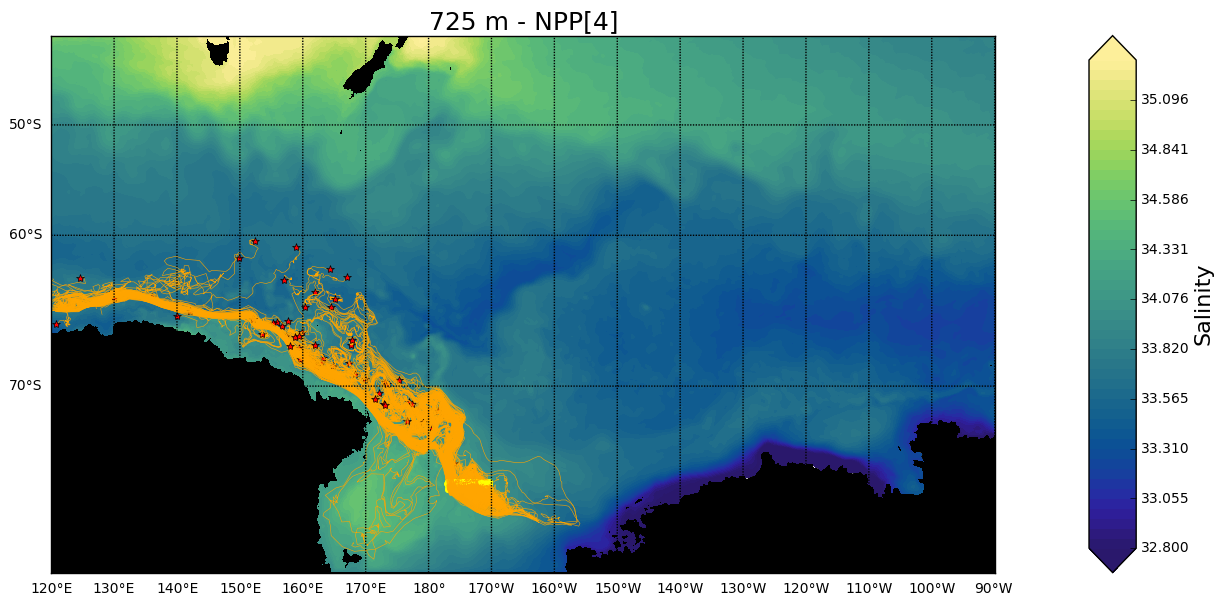

In [303]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(1000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

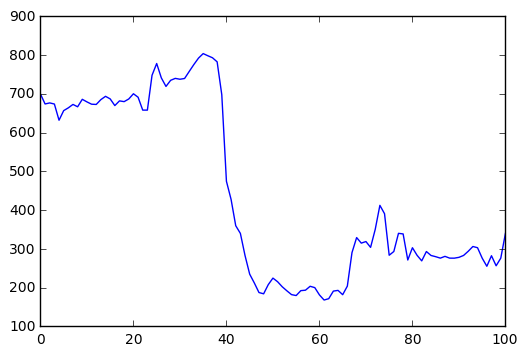

In [282]:
plt.plot(DEP[:,972])


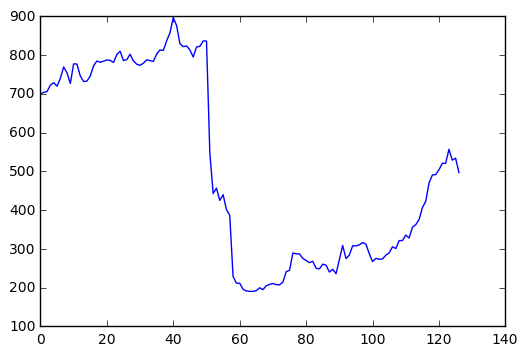

In [283]:
plt.plot(DEP[:,371])


***

# Mettre un mask sur les traj

Il a fallut mettre hFacC sur la même taille que mercator, on l'appelle hfacc

In [209]:
run /home/ebent/Octopus/Octopus-master/scripts/p_xy.py

data has 172 records
glued data : 725m_12_10_4_0004.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/725m_12_10_4/
Number of parti with z < 0 : 0
Number of parti with z > 103 (bottom of ocean) : 0


In [298]:
path = '/data/ebent/Octopus/output/725m_12_10_4/'

In [210]:
LON = np.ma.masked_array(lon, mask=False)
LAT = np.ma.masked_array(lat, mask=False)
DEP = np.ma.masked_array(dep, mask=False)

#x = np.ma.masked_array(xround, mask=False)
#y = np.ma.masked_array(yround, mask=False)
#z = np.ma.masked_array(zround, mask=False)

### Here I put a mask on hfacc==0

In [211]:
for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True: 
            continue
        if hfacc[zround[t,p], yround[t,p], xround[t,p]]==0.:
            #print t,p
            LON.mask[t:,p]=True

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti AGAIN

In [212]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué
#tmp_p = []
#tmp_t = []
for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            #print t,p
            #tmp_p.append(p)
            #tmp_t.append(t)
            LON.mask[t:,p]=True
            break

### Here I mask particles that have an initial pos out of the box I chose (this happens because of the pb of bathymetry in initial pos)

In [213]:
parti = []
for p in range(LON.shape[1]):
    if LON[0,p]<172. or LON[0,p]>190. or LAT[0,p]<-75. or LAT[0,p]>-70.:
        LON.mask[:,p]=True
        parti.append(p)

In [214]:
len(parti)

3070

On applique le mask de LON pour les autres variables

In [215]:
# Make sure all pos have the same mask
LAT.mask = LON.mask
DEP.mask = LON.mask

xround.mask = LON.mask
yround.mask = LON.mask
zround.mask = LON.mask

In [216]:
#x.mask = LON.mask
#y.mask = LON.mask
#z.mask = LON.mask

### Save the positions with masks

In [218]:
pickle_save('DEP', path, DEP)
pickle_save('LAT', path, LAT)
pickle_save('LON', path, LON)

pickle_save('zround', path, zround)
pickle_save('yround', path, yround)
pickle_save('xround', path, xround)

('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/DEP.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/LAT.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/LON.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/zround.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/yround.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/xround.npy')


***

## Test some specific particles

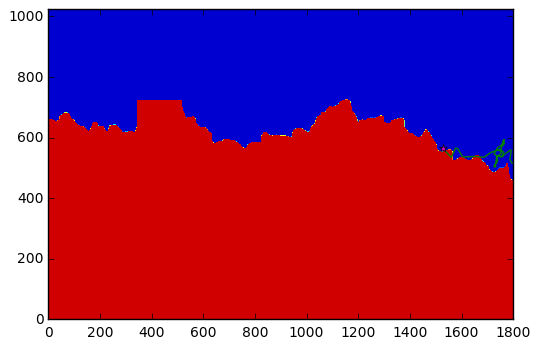

In [225]:
p = 6165
plt.contourf(xc, yc, southern_front)
plt.plot(xround[:,p],yround[:,p], '-g')
plt.plot(xround[0,p],yround[0,p], '*m')
#plt.plot(xround[77:,p],yround[77:,p], '.k')

***

# Particle analysis : count the particles according to time

In [289]:
Z1 = np.zeros(xround.shape[0])
Z2 = np.zeros(xround.shape[0])
Z3 = np.zeros(xround.shape[0])
Z4 = np.zeros(xround.shape[0])
Z5 = np.zeros(xround.shape[0])
dead = np.zeros(xround.shape[0])

for p in range(npts):
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    #print ''
    #print 'nb of parti :', p
    for t in range(xround.shape[0]):
        if south_front[t]!=0 and xround[t,p]>E_boundary and xround[t,p]<W_boundary:
            #print t, 'in RG'
            Z1[t]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
        
        elif south_front[t]==0:
            #print t, 'north'
            Z2[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break # after the break, the particle is considered forever in the zone
        elif xround[t,p]<=E_boundary:
            #print t,'out to the east'
            Z3[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]>=W_boundary:
            #print t, 'west'
            Z4[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]<=E_boundary and xround[t,p]>=W_boundary:
            #print t, 'east and west'
            Z5[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
            
        elif xround.mask[t,p]==True:
            #print t, 'parti is dead !'
            dead[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            #print Z1[t-1], Z2[t-1], Z3[t-1], Z4[t-1], Z5[t-1], dead[t-1]
            break
        ##print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]

In [290]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(6930.0, 0.0, 0.0, 0.0, 0.0, 3070.0)

In [291]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(1978.0, 128.0, 1858.0, 0.0, 0.0, 6036.0)

Verifie si les parti sont conservatives : à chaque pas de temps, la somme de chaque zone = le nb total de parti

In [296]:
print 'check at t = 0 :', Z1[0]+Z2[0]+Z3[0]+Z4[0]+Z5[0]+dead[0]
print 'check at t = end :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]
print 'check at t = 44 :', Z1[44]+Z2[44]+Z3[44]+Z4[44]+Z5[44]+dead[44]
print 'check at t = 100 :', Z1[100]+Z2[100]+Z3[100]+Z4[100]+Z5[100]+dead[100]

check at t = 0 : 10000.0
check at t = end : 10000.0
check at t = 44 : 10000.0
check at t = 100 : 10000.0


### Save the analysis of each zone

In [299]:
pickle_save('Z1', path, Z1)
pickle_save('Z2', path, Z2)
pickle_save('Z3', path, Z3)
pickle_save('Z4', path, Z4)
pickle_save('Z5', path, Z5)
pickle_save('dead', path, dead)

('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/Z1.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/Z2.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/Z3.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/Z4.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/Z5.npy')
('saved at : ', '/data/ebent/Octopus/output/725m_12_10_4/dead.npy')


***

# Plot the particle analysis


Total nb of particles that stay in the Ross Gyre : 19.78 %
Total nb of particles that go North : 1.28 %
Total nb of particles that go East : 18.58 %
Total nb of particles that go West : 0.0 %
Total nb of particles that go East then West : 0.0 %
Total number of particles : 10000.0


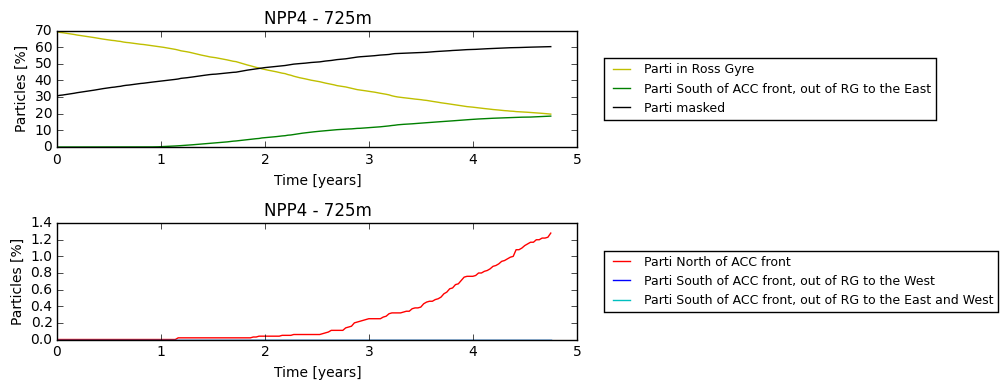

In [199]:
fig  = plt.figure()
time = (np.arange(xround.shape[0])*10)/360.

plt.subplot(2,1,1)
plt.plot(time, Z1*100./npts, '-y', label='Parti in Ross Gyre')
#plt.plot(time, Z2*100./npts, '-r', label='Parti North of ACC front')
plt.plot(time, Z3*100./npts, '-g', label='Parti South of ACC front, out of RG to the East')
#plt.plot(time, Z4*100./npts, '-b', label='Parti South of ACC front, out of RG to the West')
#plt.plot(time, Z5*100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
plt.plot(time, dead*100./npts, '-k', label='Parti masked')

plt.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
plt.xlabel('Time [years]')
plt.ylabel('Particles [%]')
plt.title('NPP4 - 725m')

plt.subplot(2,1,2)
#plt.plot(time, Z1*100./npts, '-y', label='Parti in Ross Gyre')
plt.plot(time, Z2*100./npts, '-r', label='Parti North of ACC front')
#plt.plot(time, Z3*100./npts, '-g', label='Parti South of ACC front, out of RG to the East')
plt.plot(time, Z4*100./npts, '-b', label='Parti South of ACC front, out of RG to the West')
plt.plot(time, Z5*100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
#plt.plot(time, dead*100./npts, '-k', label='Parti masked')

plt.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
plt.xlabel('Time [years]')
plt.ylabel('Particles [%]')
plt.title('NPP4 - 725m')

fig.tight_layout()

print ''
print 'Total nb of particles that stay in the Ross Gyre :', Z1[-1]*100./npts, '%'
print 'Total nb of particles that go North :', Z2[-1]*100./npts, '%'
print 'Total nb of particles that go East :', Z3[-1]*100./npts, '%'
print 'Total nb of particles that go West :', Z4[-1]*100./npts, '%'
print 'Total nb of particles that go East then West :', Z5[-1]*100./npts, '%'
print 'Total number of particles :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]

### Function to plot

In [69]:
time = (np.arange(xround.shape[0])*10)/360.
def plot1(title):
    #plt.plot(time, evo_zone1*100/npts, '-m')
    time = (np.arange(len(evo_zone2))*10)/360.
    
    plt.plot(time, evo_zone2*100./npts, '-r', label='Parti North of ACC front')
    plt.plot(time, evo_zone3*100./npts, '-g', label='Parti South of ACC front, out of RG to the East')
    plt.plot(time, evo_zone4*100./npts, '-b', label='Parti South of ACC front, out of RG to the West')
    plt.plot(time, evo_zone5*100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
    plt.plot(time, total*100./npts, '-k', label='Parti in Ross Gyre')
    
    #plt.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    plt.xlabel('Time [years]')
    plt.ylabel('Particles [%]')
    plt.title(title)

## Make figure with several NPP

IOError: [Errno 2] No such file or directory: '/data/ebent/Particle_analysis/30m/NPP4_evo_zone1.npy'

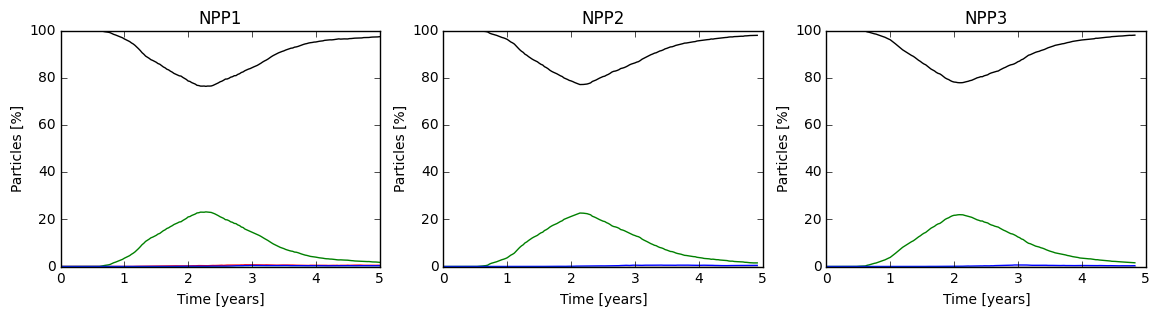

In [70]:
fig = plt.figure(figsize=(14,14))
i = 1
for NPP in NPPs:
    evo_zone1 = pickle_load(NPP + '_evo_zone1', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone2 = pickle_load(NPP + '_evo_zone2', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone3 = pickle_load(NPP + '_evo_zone3', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone4 = pickle_load(NPP + '_evo_zone4', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone5 = pickle_load(NPP + '_evo_zone5', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    total = np.ones(evo_zone2.shape[0])*10000
    total = total-evo_zone2-evo_zone3-evo_zone4-evo_zone5
    
    plt.subplot(4,3,i)
    plot1(NPP)
    i+=1
fig.tight_layout